In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
 !python --version

Python 3.10.12


In [ ]:
!pip freeze

absl-py==1.4.0
aiohttp==3.9.3
aiosignal==1.3.1
alabaster==0.7.16
albumentations==1.3.1
altair==4.2.2
annotated-types==0.6.0
anyio==3.7.1
appdirs==1.4.4
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array-record==0.5.0
arviz==0.15.1
astropy==5.3.4
astunparse==1.6.3
async-timeout==4.0.3
atpublic==4.0
attrs==23.2.0
audioread==3.0.1
autograd==1.6.2
Babel==2.14.0
backcall==0.2.0
beautifulsoup4==4.12.3
bidict==0.23.1
bigframes==0.24.0
bleach==6.1.0
blinker==1.4
blis==0.7.11
blosc2==2.0.0
bokeh==3.3.4
bqplot==0.12.43
branca==0.7.1
build==1.1.1
CacheControl==0.14.0
cachetools==5.3.3
catalogue==2.0.10
certifi==2024.2.2
cffi==1.16.0
chardet==5.2.0
charset-normalizer==3.3.2
chex==0.1.85
click==8.1.7
click-plugins==1.1.1
cligj==0.7.2
cloudpathlib==0.16.0
cloudpickle==2.2.1
cmake==3.27.9
cmdstanpy==1.2.1
colorcet==3.1.0
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confection==0.1.4
cons==0.4.6
contextlib2==21.6.0
contourpy==1.2.0
cryptography==42.0.5
cufflinks==0.17.3
cupy-cuda12x==12.2.0


In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as col
import cv2
import albumentations as A

import tensorflow as tf
from tensorflow import keras
from keras.models import load_model, save_model
from tensorflow.keras.models import *
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.metrics import *
from keras.losses import binary_crossentropy
from keras.models import Model
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import load_img, img_to_array
os.environ['SM_FRAMEWORK'] = 'tf.keras'


Mounted at /content/drive


In [ ]:
from tensorflow.keras.utils import Sequence
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img





class SegmentationDataGenerator(Sequence):
    def __init__(self, image_paths, mask_paths, batch_size, target_size=(256, 256)):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.target_size = target_size

    def __len__(self):
        return len(self.image_paths) // self.batch_size

    def __getitem__(self, idx):
      batch_image_paths = self.image_paths[idx * self.batch_size: (idx + 1) * self.batch_size]
      batch_mask_paths = self.mask_paths[idx * self.batch_size: (idx + 1) * self.batch_size]

      batch_images = np.zeros((self.batch_size,) + self.target_size + (3,), dtype=np.float32)
      batch_masks = np.zeros((self.batch_size,) + self.target_size + (1,), dtype=np.float32)

      for i, (image_path, mask_path) in enumerate(zip(batch_image_paths, batch_mask_paths)):
          image = img_to_array(load_img(image_path, target_size=self.target_size)) / 255.0
          mask = img_to_array(load_img(mask_path, color_mode='grayscale', target_size=self.target_size)) / 255.0

          if mask.ndim == 2:
              mask = np.expand_dims(mask, axis=-1)
          elif mask.ndim == 4:

              mask = np.squeeze(mask, axis=-1)

          batch_images[i] = image
          batch_masks[i] = mask

      return batch_images, batch_masks



In [ ]:
import os

def get_image_mask_paths(base_dir, category):
    image_dir = os.path.join(base_dir, category, 'images')
    mask_dir = os.path.join(base_dir, category, 'lung masks')

    image_paths, mask_paths = [], []


    if not os.path.isdir(image_dir):
        print(f"Image directory {image_dir} not found.")
        return image_paths, mask_paths

    images = [img for img in sorted(os.listdir(image_dir)) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]

    for img_name in images:
        base_name = os.path.splitext(img_name)[0]

        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, base_name + '.png')

        if os.path.exists(mask_path):
            image_paths.append(img_path)
            mask_paths.append(mask_path)
        else:
            print(f"Mask for image {img_name} not found.")

    return image_paths, mask_paths

def collect_dataset_paths(base_dir):
    all_image_paths, all_mask_paths = [], []

    for category in ['Non-COVID', 'Normal']:
        image_paths, mask_paths = get_image_mask_paths(base_dir, category)
        all_image_paths.extend(image_paths)
        all_mask_paths.extend(mask_paths)

    return all_image_paths, all_mask_paths

def get_file_count(paths):
    return len(paths)


base_dataset_dir = '/content/drive/Othercomputers/My Laptop/Lung Segmentation Data'

train_image_paths, train_mask_paths = collect_dataset_paths(os.path.join(base_dataset_dir, 'Train'))
val_image_paths, val_mask_paths = collect_dataset_paths(os.path.join(base_dataset_dir, 'Val'))
test_image_paths, test_mask_paths = collect_dataset_paths(os.path.join(base_dataset_dir, 'Test'))


train_image_count = get_file_count(train_image_paths)
train_mask_count = get_file_count(train_mask_paths)
val_image_count = get_file_count(val_image_paths)
val_mask_count = get_file_count(val_mask_paths)
test_image_count = get_file_count(test_image_paths)
test_mask_count = get_file_count(test_mask_paths)


print("Train images:", train_image_count)
print("Train masks:", train_mask_count)
print("Val images:", val_image_count)
print("Val masks:", val_mask_count)
print("Test images:", test_image_count)
print("Test masks:", test_mask_count)


Train images: 14057
Train masks: 14057
Val images: 3514
Val masks: 3514
Test images: 4393
Test masks: 4393


In [ ]:


train_generator = SegmentationDataGenerator(train_image_paths, train_mask_paths, batch_size=8, target_size=(256, 256))
val_generator = SegmentationDataGenerator(val_image_paths, val_mask_paths, batch_size=8, target_size=(256, 256))
test_generator = SegmentationDataGenerator(test_image_paths, test_mask_paths, batch_size=8, target_size=(256, 256))


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout, BatchNormalization,Concatenate,GlobalAveragePooling2D,Dense,Multiply
from tensorflow.keras.applications import VGG16


In [ ]:
def IoU(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou
def DiceScore(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    dice = (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)
    return dice
def Precision(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    true_positives = tf.reduce_sum(y_true * y_pred)
    predicted_positives = tf.reduce_sum(y_pred)
    precision = true_positives / (predicted_positives + 1e-6)
    return precision

In [ ]:
def se_block(input_tensor, ratio=16):
    channel_axis = -1
    filters = input_tensor.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(input_tensor)
    se = Dense(filters // ratio, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)
    se = tf.reshape(se, [-1, 1, 1, filters])
    return Multiply()([input_tensor, se])

In [ ]:
def pyramid_pooling_block(input_tensor, bin_sizes=[1, 2, 4, 6]):
    concat_list = [input_tensor]
    for bin_size in bin_sizes:
        x = MaxPooling2D(pool_size=(bin_size, bin_size))(input_tensor)
        x = Conv2D(input_tensor.shape[-1], (3, 3), padding='same')(x)
        x = tf.image.resize(x, (input_tensor.shape[1], input_tensor.shape[2]))
        concat_list.append(x)
    return Concatenate()(concat_list)


In [ ]:
def vgg16_encoder(input_tensor, freeze_layers=8):
    vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)

    for layer in vgg16.layers[:freeze_layers]:
        layer.trainable = False

    skip_connections = ['block1_conv2', 'block2_conv2', 'block3_conv3', 'block4_conv3']
    encoder_outputs = [vgg16.get_layer(name).output for name in skip_connections]

    return Model(inputs=vgg16.input, outputs=encoder_outputs, name='vgg16_encoder')


In [ ]:
def decoder_block(input_tensor, concat_tensor, num_filters):

    x = Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
    x = tf.image.resize(x, size=(tf.shape(concat_tensor)[1], tf.shape(concat_tensor)[2]))
    x = concatenate([x, concat_tensor])
    x = se_block(x)
    x = Conv2D(num_filters, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(num_filters, (3, 3), activation='relu', padding='same')(x)
    return x


In [ ]:
def build_unet(input_shape):
    inputs = Input(shape=input_shape)

    # Encoder
    encoder = vgg16_encoder(inputs)
    encoder_outputs = encoder.outputs

    # Bottleneck
    bottleneck = Conv2D(512, (3, 3), activation='relu', padding='same')(encoder_outputs[-1])
    bottleneck = Conv2D(512, (3, 3), activation='relu', padding='same')(bottleneck)
    bottleneck = pyramid_pooling_block(bottleneck)

    # Decoder
    decoder = decoder_block(bottleneck, encoder_outputs[-2], 256)
    decoder = decoder_block(decoder, encoder_outputs[-3], 128)
    decoder = decoder_block(decoder, encoder_outputs[-4], 64)
    decoder = decoder_block(decoder, encoder.outputs[0], 32)

    # Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(decoder)

    model = Model(inputs=[inputs], outputs=[outputs], name='VGG16_U-Net')
    return model


In [ ]:
input_shape = (256, 256, 3)
model = build_unet(input_shape)
metrics = [IoU, DiceScore, Precision]
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[metrics,'accuracy'])
model.summary()


58889256/58889256 [==============================] - 4s 0us/step
Model: "VGG16_U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 256, 256, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)         0         ['block1_conv2[0][0]']        
                       

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint('/content/drive/MyDrive/FYP/Implemention/v_unet_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001, verbose=1)

callbacks_list = [checkpoint, early_stopping, reduce_lr]


In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=callbacks_list,
    verbose=1,
    use_multiprocessing=True,
    workers=4
)


Epoch 1/20
1757/1757 [==============================] - ETA: 0s - loss: 0.0603 - IoU: 0.9042 - DiceScore: 0.9442 - Precision: 0.9509 - accuracy: 0.9766
Epoch 1: val_loss improved from inf to 0.03686, saving model to /content/drive/MyDrive/FYP/Implemention/v_unet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1757/1757 [==============================] - 7240s 4s/step - loss: 0.0603 - IoU: 0.9042 - DiceScore: 0.9442 - Precision: 0.9509 - accuracy: 0.9766 - val_loss: 0.0369 - val_IoU: 0.9395 - val_DiceScore: 0.9685 - val_Precision: 0.9758 - val_accuracy: 0.9861 - lr: 0.0010
Epoch 2/20
1757/1757 [==============================] - ETA: 0s - loss: 0.0376 - IoU: 0.9379 - DiceScore: 0.9676 - Precision: 0.9717 - accuracy: 0.9852
Epoch 2: val_loss improved from 0.03686 to 0.03243, saving model to /content/drive/MyDrive/FYP/Implemention/v_unet_model.h5
1757/1757 [==============================] - 150s 85ms/step - loss: 0.0376 - IoU: 0.9379 - DiceScore: 0.9676 - Precision: 0.9717 - accuracy: 0.9852 - val_loss: 0.0324 - val_IoU: 0.9435 - val_DiceScore: 0.9707 - val_Precision: 0.9716 - val_accuracy: 0.9870 - lr: 0.0010
Epoch 3/20
1757/1757 [==============================] - ETA: 0s - loss: 0.0339 - IoU: 0.9435 - DiceScore: 0.9706 - Precision: 0.9737 - accuracy: 0.9865
Epoch 3: val_loss improved from 0.0

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.utils import CustomObjectScope

In [ ]:

print("Evaluate")
result = model.evaluate(test_generator)
dict(zip(model.metrics_names, result))

Evaluate
549/549 [==============================] - 7495s 14s/step - loss: 0.0240 - IoU: 0.9564 - DiceScore: 0.9776 - Precision: 0.9812 - accuracy: 0.9901


{'loss': 0.02396480366587639,
 'IoU': 0.9564315676689148,
 'DiceScore': 0.9775972962379456,
 'Precision': 0.9812048673629761,
 'accuracy': 0.9900977611541748}

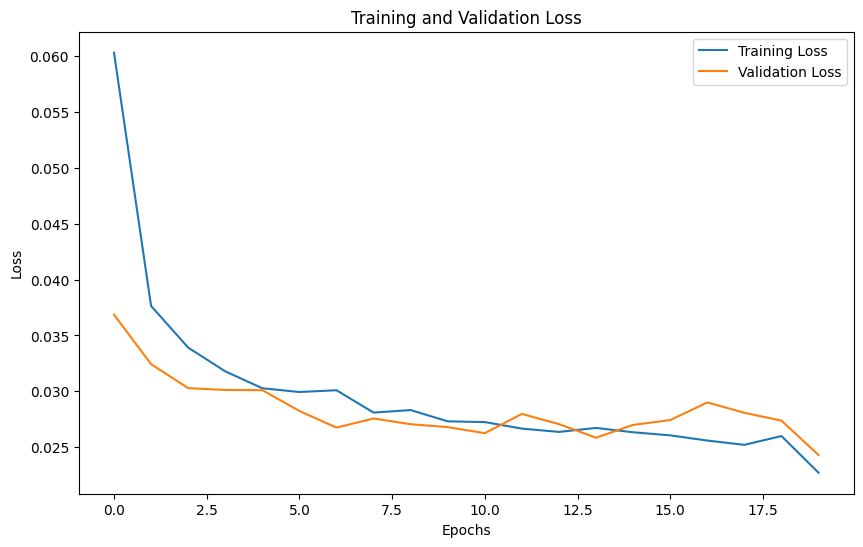

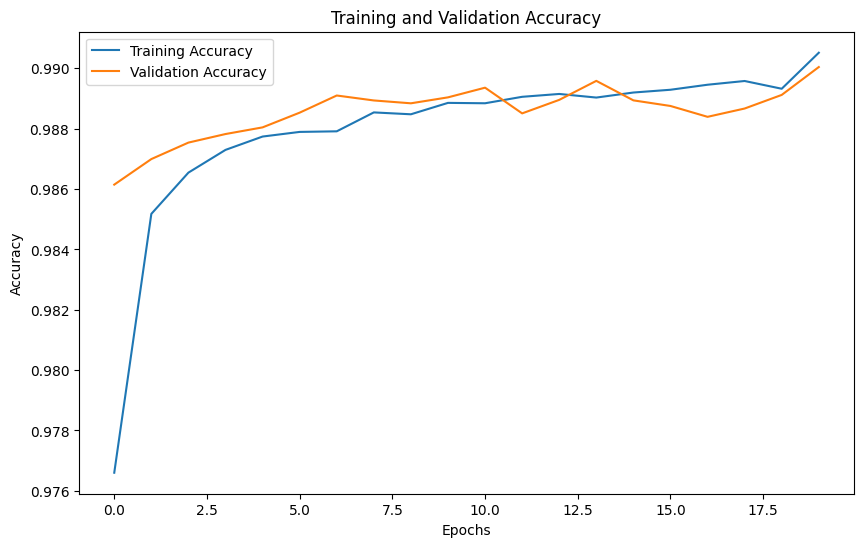

In [ ]:
import matplotlib.pyplot as plt

# Plot Training and Validation Loss
def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Plot Training and Validation Accuracy
def plot_accuracy(history):

    acc_key = 'accuracy' if 'accuracy' in history.history else 'acc'
    val_acc_key = 'val_accuracy' if 'val_accuracy' in history.history else 'val_acc'

    plt.figure(figsize=(10, 6))
    plt.plot(history.history[acc_key], label='Training Accuracy')
    plt.plot(history.history[val_acc_key], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


plot_loss(history)
plot_accuracy(history)



In [ ]:
from keras.models import load_model
import tensorflow as tf


def IoU(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

def DiceScore(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    dice = (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)
    return dice

def Precision(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    true_positives = tf.reduce_sum(y_true * y_pred)
    predicted_positives = tf.reduce_sum(y_pred)
    precision = true_positives / (predicted_positives + 1e-6)
    return precision

# Load the model with custom metrics
model_path = '/content/drive/MyDrive/FYP/Implemention/v_unet_model.h5'
custom_objects = {'IoU': IoU, 'DiceScore': DiceScore, 'Precision': Precision}
model = load_model(model_path, custom_objects=custom_objects)


In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np

def preprocess_image(image_path, target_size):

    img = load_img(image_path, target_size=target_size, color_mode='rgb')
    img = img_to_array(img) / 255.0
    img = np.expand_dims(img, axis=0)
    return img


image_path = '/content/drive/MyDrive/Final Year Project/FYP_Implemention/images (5).jpeg'
input_img = preprocess_image(image_path, target_size=(256, 256))


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Final Year Project/FYP_Implemention/images (5).jpeg'

In [ ]:

pred_mask = model.predict(input_img)


1/1 [==============================] - 4s 4s/step


In [ ]:

threshold = 0.5
pred_mask = (pred_mask > threshold).astype(np.uint8)


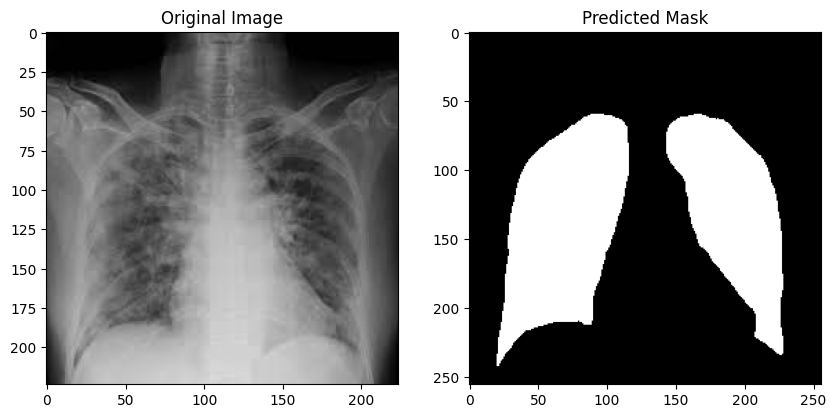

In [ ]:
import matplotlib.pyplot as plt


pred_mask = pred_mask.squeeze()


plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(load_img(image_path))

plt.subplot(1, 2, 2)
plt.title('Predicted Mask')
plt.imshow(pred_mask, cmap='gray')

plt.show()


In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

def IoU(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

def DiceScore(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    dice = (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)
    return dice

def Precision(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    true_positives = tf.reduce_sum(y_true * y_pred)
    predicted_positives = tf.reduce_sum(y_pred)
    precision = true_positives / (predicted_positives + 1e-6)
    return precision


model_path = '/content/drive/MyDrive/FYP/Implemention/my_model.keras'
custom_objects = {'IoU': IoU, 'DiceScore': DiceScore, 'Precision': Precision}
model = load_model(model_path, custom_objects=custom_objects)

def preprocess_image(image_path, target_size=(256, 256)):
    """Read and preprocess an image for the U-Net model."""
    img = cv2.imread(image_path)
    img = cv2.resize(img, target_size)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

def save_segmented_image(image, save_path):
    """Save the segmented image."""
    cv2.imwrite(save_path, image)

def segment_and_save(image_paths, base_save_dir):
    for image_path in image_paths:

        preprocessed_img = preprocess_image(image_path)

        predicted_mask = model.predict(preprocessed_img)[0]


        segmented_img = (predicted_mask > 0.5) * 255
        segmented_img = segmented_img.astype(np.uint8)


        relative_path = os.path.relpath(image_path, start=os.path.commonpath(image_paths))
        save_path = os.path.join(base_save_dir, relative_path)


        os.makedirs(os.path.dirname(save_path), exist_ok=True)

        save_segmented_image(segmented_img, save_path)


In [ ]:
base_save_dir_test = '/content/drive/MyDrive/FYP/Dataset/Classification/Test'
base_save_dir_val = '/content/drive/MyDrive/FYP/Dataset/Classification/Val'
base_save_dir_train = '/content/drive/MyDrive/FYP/Dataset/Classification/Train'


segment_and_save(train_image_paths, base_save_dir_train)


segment_and_save(val_image_paths, base_save_dir_val)


segment_and_save(test_image_paths, base_save_dir_test)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 30ms/step
